# Prepare Dataset
> Note: Colab only

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r /content/drive/MyDrive/Capstone/Eye-Infection-Dataset/ .
!mv ./Eye-Infection-Dataset ./dataset
!rm ./dataset/LICENSE.md
!mkdir export

# Setup

In [16]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from io import BytesIO
from ipywidgets import widgets
from google.colab import files

In [4]:
DATASET_PATH = './dataset'
CLASSES = sorted(os.listdir(DATASET_PATH))
IMAGE_SIZE=(150, 150)

# Data Processing

In [5]:
train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    image_size=IMAGE_SIZE,
    label_mode='categorical',
    validation_split=0.2,
    subset='both',
    batch_size=32,
    seed=8
)

Found 615 files belonging to 3 classes.
Using 492 files for training.
Using 123 files for validation.


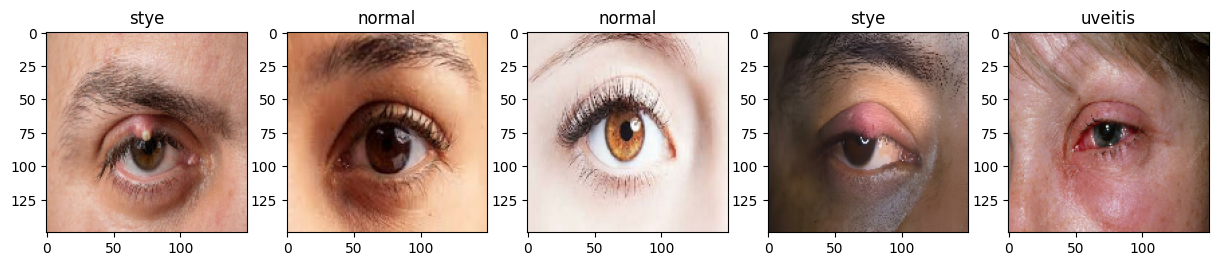

In [6]:
imgs = list(train_ds.take(5))[0]

# print(imgs)

plot, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))

for i, ax in enumerate(axes):
  img = tf.keras.utils.array_to_img(imgs[0][i])
  lbl = CLASSES[np.argmax(imgs[1][i].numpy())]

  ax.title.set_text(lbl)
  ax.imshow(img)

In [7]:
def preprocess_image(image):
  image = tf.cast(image, tf.float32)
  image /= 255.0
  return image

In [8]:
train_ds = train_ds.map(lambda x, y: (preprocess_image(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_image(x), y))

In [9]:
train_ds_pref = train_ds.cache().shuffle(64).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds_pref = val_ds.cache().shuffle(64).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Setup

In [10]:
class CustomCallback(tf.keras.callbacks.Callback):
  def __init__(self):
    super(CustomCallback, self).__init__()
    self.prev_acc = 0.0

  def on_epoch_end(self, epoch, logs=None):
    self.prev_acc = logs['accuracy']

    # Early stop when there is no accuracy or loss improvement
    if epoch > 30 and self.prev_acc < 0.5:
      self.model.stop_training = True
      print("\nStopped the training because there is no improvement")

    # Early stop when the model has achieved the desired accuracy
    if (logs['loss'] < 0.1 and logs['val_loss'] < 0.1) and (logs['accuracy'] >= 0.95 and logs['val_accuracy'] >= 0.95):
      self.model.stop_training = True
      print("\nAlready met the desired accuracy")

In [11]:
tf.keras.backend.clear_session()

In [12]:
model_aug = tf.keras.models.Sequential([
    tf.keras.Input(shape=IMAGE_SIZE + (3,)),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom((0.0, 0.2), (0.0, 0.2), fill_mode="nearest", seed=16)
])

In [13]:
model = tf.keras.models.Sequential([
    model_aug,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(512, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.1), activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax'),
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 5, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,619,203 (9.99 MB)

 Trainable params: 2,619,203 (9.99 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5.6234e-04),
    loss=tf.keras.losses.Huber(),
    metrics=['accuracy']
)

model_obj = model.fit(
    train_ds,
    epochs=100,
    batch_size=16,
    validation_data=val_ds,
    callbacks=[CustomCallback()]
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.3998 - loss: 71.6777 - val_accuracy: 0.4309 - val_loss: 44.7873
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.4159 - loss: 38.4732 - val_accuracy: 0.4959 - val_loss: 22.5538
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5094 - loss: 19.0777 - val_accuracy: 0.4390 - val_loss: 10.5779
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.4904 - loss: 8.8264 - val_accuracy: 0.4472 - val_loss: 4.6506
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.4837 - loss: 3.8319 - val_accuracy: 0.5447 - val_loss: 1.9264
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.4937 - loss: 1.5729 - val_accuracy: 0.5447 - val_loss: 0.7729
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.5580 - loss: 0.6414 - val_accuracy: 0.6667 - val_loss: 0.3343
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.6057 - loss: 0.2777 - val_acc

# Model Tuning (Experiment)
> This section is only for experiment. Therefore, optional. Make sure you haven't compile or train the model yet!

In [ ]:
# Learning rate scheduler

tf.keras.backend.clear_session()

model_aug = tf.keras.models.Sequential([
    tf.keras.Input(shape=IMAGE_SIZE + (3,)),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom((0.0, 0.2), (0.0, 0.2), fill_mode="nearest", seed=16)
])

model = tf.keras.models.Sequential([
    model_aug,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(512, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.1), activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax'),
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10 ** (epoch / 20))

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mae']
)

model_obj = model.fit(
    train_ds,
    epochs=100,
    batch_size=16,
    validation_data=val_ds,
    callbacks=[lr_schedule]
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 81.9220 - mae: 0.4452 - val_loss: 81.8609 - val_mae: 0.4452 - learning_rate: 1.0000e-06
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 81.8383 - mae: 0.4449 - val_loss: 81.7698 - val_mae: 0.4448 - learning_rate: 1.1220e-06
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 81.7447 - mae: 0.4448 - val_loss: 81.6676 - val_mae: 0.4444 - learning_rate: 1.2589e-06
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 81.6395 - mae: 0.4443 - val_loss: 81.5531 - val_mae: 0.4439 - learning_rate: 1.4125e-06
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 81.5217 - mae: 0.4440 - val_loss: 81.4250 - val_mae: 0.4434 - learning_rate: 1.5849e-06
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 81.3896 - mae: 0.4433 - val_loss: 81.2813 - val_mae: 0.4428 - learning_rate: 1.7783e-06
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 81.2418 - mae: 0.4429 - val_loss: 81.1205 - val_mae

In [ ]:
def demo_augmentation(sample_image, model, num_aug):
    '''Takes a single image array, then uses a model to generate num_aug transformations'''

    # Instantiate preview list
    image_preview = []

    # Convert input image to a PIL image instance
    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    # Append the result to the list
    image_preview.append(sample_image_pil)

    # Apply the image augmentation and append the results to the list
    for i in range(num_aug):
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    # Instantiate a subplot
    fig, axes = plt.subplots(1, num_aug + 1, figsize=(12, 12))

    # Preview the images.
    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()

        if index == 0:
            ax.set_title('original')
        else:
            ax.set_title(f'augment {index}')

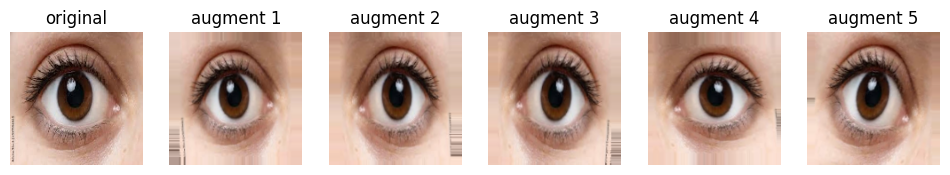

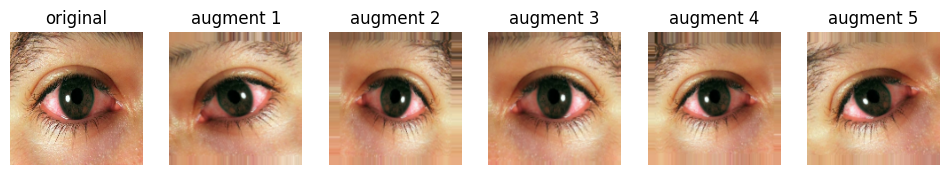

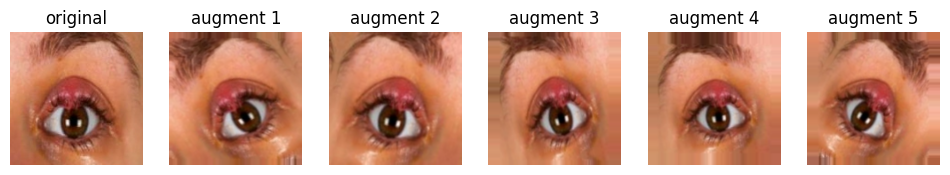

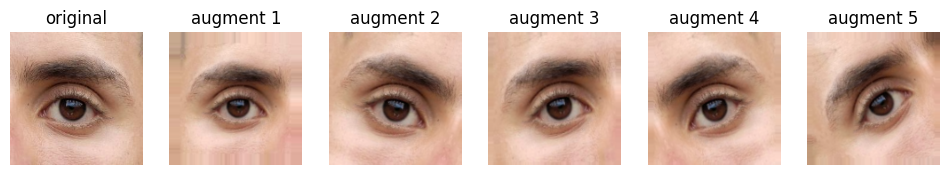

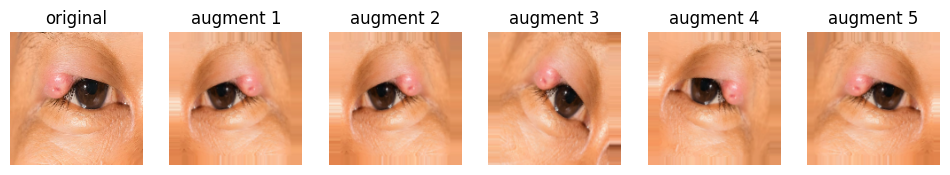

In [ ]:
sample_batch = list(train_ds.take(1))[0][0]

for i in range(5):
  demo_augmentation(sample_batch[i], model_aug, 5)

# Model Evaluation

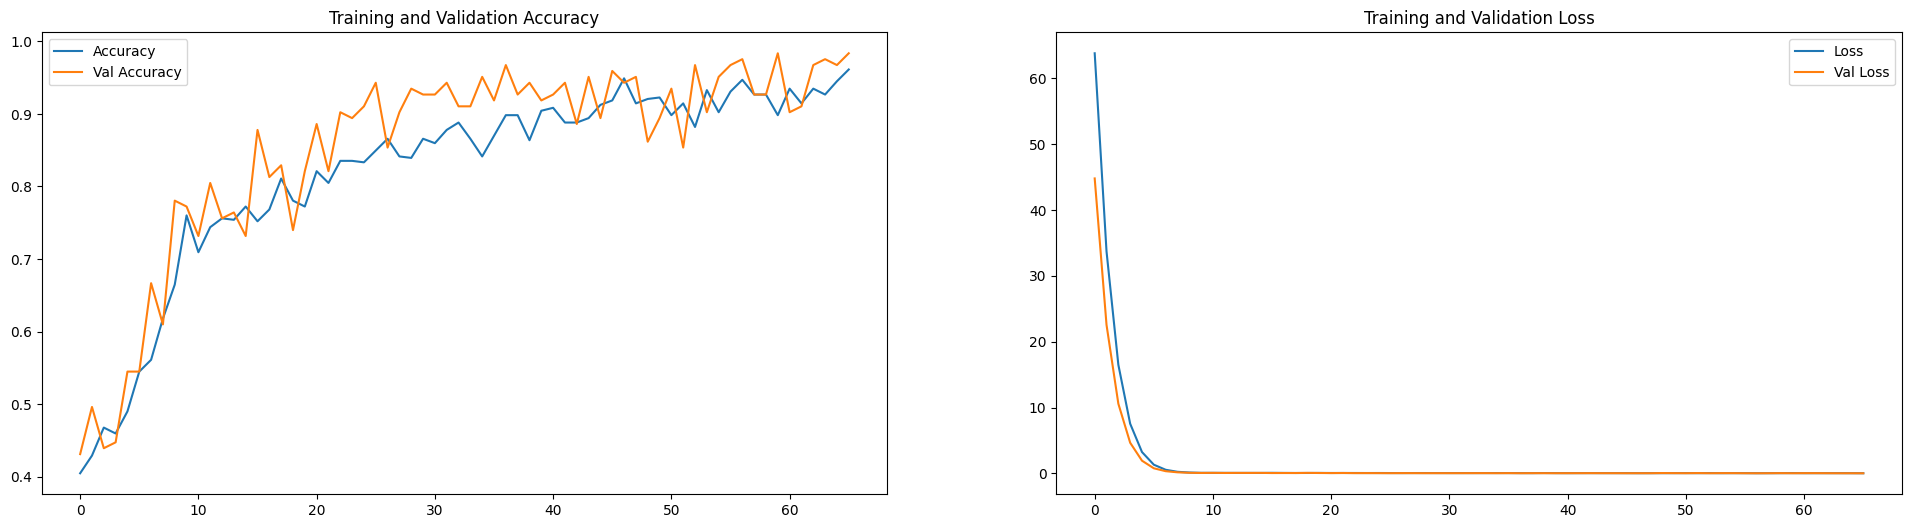

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(24, 6))

ax[0].plot(model_obj.history['accuracy'], label='Accuracy')
ax[0].plot(model_obj.history['val_accuracy'], label='Val Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend()

ax[1].plot(model_obj.history['loss'], label='Loss')
ax[1].plot(model_obj.history['val_loss'], label='Val Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].legend()

plt.show()

# Testing

Saving th-4019506594.jpeg to th-4019506594.jpeg
Probability: [0.00156708 0.99394244 0.00449044]
Prediction: stye



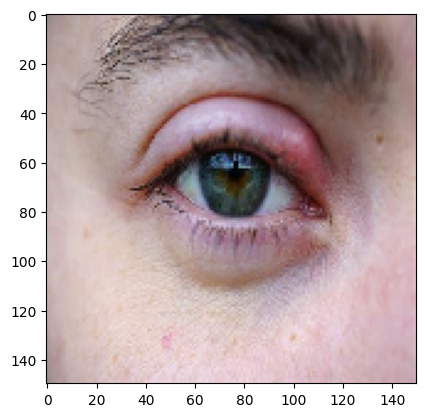

In [ ]:
uploaded = files.upload()

for f in uploaded.keys():
  img = tf.keras.preprocessing.image.load_img(f, target_size=IMAGE_SIZE)

  plt.imshow(img)

  img = tf.keras.utils.img_to_array(img)
  img /= 255.0
  img = tf.expand_dims(img, axis=0)

  prediction = model.predict(img, verbose=0)[0]

  print(f'Probability: {prediction}')
  print(f'Prediction: {CLASSES[np.argmax(prediction)]}\n')

# Model Export

In [18]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('./export/eye-infection.tflite')
tflite_model_file.write_bytes(tflite_model)

Saved artifact at '/tmp/tmphuk4urx8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  134014068701168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134010855666640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134011099674608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134010856000848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134010856002608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134010855999088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134010856004368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134010856001376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134010856006128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134010856003136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134010856003

10482080